In [33]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

In [34]:
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Pooling Algorithm on Vertices in a 3D Model to Reduce Vertex Count

In this report I attempt to run a pooling function on the vertices of a 3D model to reduce the density and memory size of the mesh. The attribution for this model goes to ferrumiron6 with their model human-foot-base-mesh.

To start with, I first exported the coordinates of all the vertices in the model to csv.

Let's load this data into this report.

## Import Data

In [35]:
df = pd.read_csv("../data/vertexcoordinates.csv")
df.head()

,Name,Vertex_Index,X,Y,Z
0,Cube,0,0.059608,0.047925,0.383419
1,Cube,1,-0.030599,0.020009,-0.016010
2,Cube,2,0.052395,-0.102574,0.402345
3,Cube,3,0.049393,0.022423,-0.015811
4,Cube,4,-0.061567,0.066727,0.421855


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          800 non-null    object 
 1   Vertex_Index  800 non-null    int64  
 2   X             800 non-null    float64
 3   Y             800 non-null    float64
 4   Z             800 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 31.4+ KB


Here we see that we have no null values in this dataset, with a total of 800 vertices.

In theory, the coordinates for these vertices should corresponds to points in space, and to confirm that we have loaded our data accurately, lets plot some charts. We start with 3 point charts for each combination of our columns, X-Y, X-Z and Y-Z.

In [67]:
# Create the point chart between X and Y
xy_point = alt.Chart(df).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Y').scale(domain=[-0.8,0.2])
).properties(
    width = 250,
    height = 350
)

# Create the point chart between X and Z
xz_point = alt.Chart(df).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 250,
    height = 300
)

# Create the point chart between Y and Z
yz_point = alt.Chart(df).mark_point().encode(
    x = alt.X('Y').scale(domain=[-0.8,0.2]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 400,
    height = 300
)

In [38]:
vertex_point = (xz_point | yz_point) & xy_point
vertex_point

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.VConcatChart(...)

We observe that our vertices indeed do capture the general shape of our foot. Lets see what these points look like on a 3D chart.

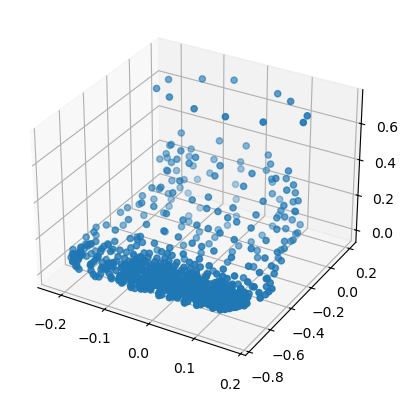

In [39]:
foot_fig_orig = plt.figure().add_subplot(projection='3d')
foot_fig_orig.scatter(df['X'], df['Y'], df['Z'])

## Converting to Numpy Array

Converting our 3D scene to a numpy array requires some thinking on how best to approach. Lets start by assessing what we would like our end goal to be here. I would like the output of the pooling funtion to move a specific sized cube as a window across our entire scene, replacing each of our points in the scene with the center of mass of the cube, effectively reducing the mesh density of our object. The smaller our cube is, the more generalized our object would become, while a larger window would result in greater compression.

In order to do this, I will need to create a 3x3 numpy array that encapsulates the entire scene.

Given the precision of each of our vertices, I will need to decide a decimal point cutoff, so as to minimize the amount of memory we use.

Then, I will need to initialize my array with elements corresponding to the vertiex coordinates with 1, and all others to be 0. Let's start by creating this array. To begin, lets round off our data points to 3 decimal points.

In [40]:
# Round data points to 3 decimals

df_round = df.round(3)
df_round.head()

,Name,Vertex_Index,X,Y,Z
0,Cube,0,0.060,0.048,0.383
1,Cube,1,-0.031,0.020,-0.016
2,Cube,2,0.052,-0.103,0.402
3,Cube,3,0.049,0.022,-0.016
4,Cube,4,-0.062,0.067,0.422


Let's drop our `Name` column and convert the `Vertex_Index` column to be the index of our dataframe.

In [41]:
df_round = df_round.drop(columns = ['Name'])
df_round = df_round.set_index('Vertex_Index')
df_round.head()

,X,Y,Z
Vertex_Index,,,
0,0.060,0.048,0.383
1,-0.031,0.020,-0.016
2,0.052,-0.103,0.402
3,0.049,0.022,-0.016
4,-0.062,0.067,0.422


Now lets convert to integer numbers.

In [42]:
df_round = df_round*1000
df_round = df_round.astype(int)
df_round.head()

,X,Y,Z
Vertex_Index,,,
0,60,48,383
1,-31,20,-16
2,52,-103,402
3,49,22,-16
4,-62,67,422


Now we can use these amended coordinates to create our numpy array.

I'm sure there is a more eloquent way to do this, but for simplicity let's brute force our way to this solution. First thing we need is the upper and lower bound of our array. We find the max and min of each coordinate in our dataframe.

In [43]:
df_round.describe()

,X,Y,Z
count,800.000000,800.000000,800.000000
mean,-1.867500,-533.118750,89.093750
std,97.607679,221.362053,112.237021
min,-225.000000,-762.000000,-16.000000
25%,-78.000000,-671.000000,35.000000
50%,0.000000,-614.000000,59.000000
75%,84.250000,-532.500000,91.250000
max,181.000000,197.000000,730.000000


We need to shift our values by the min, such that the smallest point in our array is at 0,0,0.

In [44]:
df_round_shifted = df_round.copy()

# Shift the X coordinate-->
df_round_shifted['X'] = df_round_shifted['X'] + abs(df_round_shifted['X'].min())

# Shift the Y coordinate-->
df_round_shifted['Y'] = df_round_shifted['Y'] + abs(df_round_shifted['Y'].min())

# Shift the Z coordinate-->
df_round_shifted['Z'] = df_round_shifted['Z'] + abs(df_round_shifted['Z'].min())

df_round_shifted.head()

,X,Y,Z
Vertex_Index,,,
0,285,810,399
1,194,782,0
2,277,659,418
3,274,784,0
4,163,829,438


Looking at our shifted values now, we can get an upper bound on the required size of our array.

In [45]:
df_round_shifted.describe()

,X,Y,Z
count,800.000000,800.000000,800.000000
mean,223.132500,228.881250,105.093750
std,97.607679,221.362053,112.237021
min,0.000000,0.000000,0.000000
25%,147.000000,91.000000,51.000000
50%,225.000000,148.000000,75.000000
75%,309.250000,229.500000,107.250000
max,406.000000,959.000000,746.000000


From the dataframe above, we see the upper bound for our data is at `X=406`, `Y=959` and `Z=746`.

Let's create an array of zeroes corresponding to this size.

In [46]:
vertex_arr = np.zeros((407,960,747)) # We add 1 due to indexing in python starting from 0
vertex_arr

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Now, we need to convert our three coordinates into one tuple, for each vertex. We do this by creating a list of tuples.

In [47]:
# Convert individual vertex coordinates to tuple
vertices = df_round_shifted.apply(lambda i: tuple(i), axis=1)

# Create list of tuples
vertices = vertices.tolist()
vertices

[(285, 810, 399),
 (194, 782, 0),
 (277, 659, 418),
 (274, 784, 0),
 (163, 829, 438),
 (132, 665, 38),
 (128, 610, 466),
 (343, 770, 25),
 (195, 691, 24),
 (270, 694, 8),
 (219, 602, 450),
 (168, 585, 470),
 (194, 874, 4),
 (258, 621, 17),
 (210, 894, 409),
 (263, 883, 398),
 (339, 838, 27),
 (279, 869, 11),
 (337, 753, 427),
 (323, 692, 407),
 (92, 665, 450),
 (94, 750, 474),
 (114, 847, 8),
 (111, 748, 13),
 (300, 622, 21),
 (340, 682, 21),
 (169, 615, 33),
 (204, 620, 25),
 (347, 785, 295),
 (64, 738, 320),
 (212, 583, 398),
 (348, 666, 287),
 (121, 601, 420),
 (364, 735, 289),
 (195, 906, 302),
 (156, 574, 434),
 (59, 687, 335),
 (256, 899, 300),
 (269, 616, 364),
 (103, 789, 329),
 (349, 327, 135),
 (393, 300, 25),
 (81, 315, 201),
 (96, 300, 16),
 (168, 260, 9),
 (163, 313, 199),
 (251, 263, 5),
 (225, 319, 174),
 (328, 270, 4),
 (274, 318, 168),
 (30, 317, 25),
 (32, 303, 141),
 (220, 474, 280),
 (216, 401, 223),
 (265, 411, 210),
 (265, 482, 257),
 (334, 415, 172),
 (312, 507, 

And now, lets fill our array with 1's wherever we have coordinates for a vertex in our object. This is done through tuple unpacking.

In [48]:
# For every vertex coordinate in the array, make it 1.
for v in vertices:
    i, j, k = v
    vertex_arr[i][j][k] = 1

Check to ensure that we have 800 points in our array -->

In [49]:
np.sum(vertex_arr)

np.float64(800.0)

Good. Now we have an array containing data points for each of our vertices in our 3D object.

## Defining the Function

Our function will work by moving a cube of a set size across our 3D object and returning the center of mass of each of the points in that cube. The center of mass is meant to be a representation of a single vertex that captures the information of all it's neighboring ones. This way, very dense parts of our 3D model should be compressed more than sparse parts.

There is probably a better way to do this, but as a first pass, I define the center of mass function as below.

In [ ]:
# define the Center of Mass function
def com(input_arr):
    '''
    Given an input 3D array, returns a 3D array with one non zero value corresponding to the center of mass.

    params
    -input_arr: np.array() object

    returns
    -np.array() object
    '''
    i, j, k = input_arr.shape
    
    lst_x = list()
    lst_y = list()
    lst_z = list()
    
    for x in range(i):
        for y in range(j):
            for z in range(k):
                if input_arr[x][y][z] != 0:
                    lst_x.append(x)
                    lst_y.append(y)
                    lst_z.append(z)
    
    com_x = int(sum(lst_x)/len(lst_x)) # calculating the mean of all x coordinates
    com_y = int(sum(lst_y)/len(lst_y)) # calculating the mean of all y coordinates
    com_z = int(sum(lst_z)/len(lst_z)) # calculating the mean of all z coordinates

    ret_array = np.zeros((i, j, k))
    ret_array[com_x][com_y][com_z] = 1
    
    return ret_array


This function works by looping though the supplied cube, and creating 3 lists for the X, Y and Z coordinates of every point that is not a 0. This way, when we take the average across these values, we will get a single value for of the coordinate that will be the 'center of mass' of that cube.

To test our function, create a random 3x3 array. In this array, we purposely put more 1's closer to the north west corner to see if our center of mass gets skewed.

In [51]:
test_arr = np.array([[[1,1,0],[1,0,0],[1,0,1]],[[1,0,0],[1,0,0],[1,0,1]],[[0,0,0],[1,0,0],[0,0,1]]])
test_arr


array([[[1, 1, 0],
        [1, 0, 0],
        [1, 0, 1]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 1]],

       [[0, 0, 0],
        [1, 0, 0],
        [0, 0, 1]]])

In [65]:
com(test_arr)

array([[[0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

The center of mass does look to be pushed out to the left.

Let's now loop our cube over the entire array. First thing we need to do is determine the cube size. To start, lets choose a 10x10x10 cube. We add the `try / except` condition to ensure that we don't run into an overflow error when our input array is not exactly divisible by 10.

In [54]:
for i in range(0,407,10):
    for j in range(0,960,10):
        for k in range(0,747,10):
            try:
                edit_arr = com(vertex_arr[i:i+9][j:j+9][k:k+9])
                vertex_arr[i:i+9][j:j+9][k:k+9] = edit_arr
            except:
                continue

That seemed to have worked. Let's get the coordinates of the non zero elemtents out.

In [55]:
new_indices = np.nonzero(vertex_arr)
x_coord, y_coord, z_coord = new_indices

new_df = pd.DataFrame({
    'X_transformed': x_coord,
    'Y_transformed': y_coord,
    'Z_transformed': z_coord
})
new_df.head()

,X_transformed,Y_transformed,Z_transformed
0,3,200,71
1,13,134,66
2,23,140,70
3,29,83,105
4,33,119,100


How many rows do we have in this new dtaset? This will give us an idea of how compressed the data got.

In [56]:
len(new_df)

130

130 new vertices exist in our object. This is a high degree of compression, a compression ratio of roughly 6.15.

Before un-normalizing our data, lets create a quick plot to see what our data looks like.

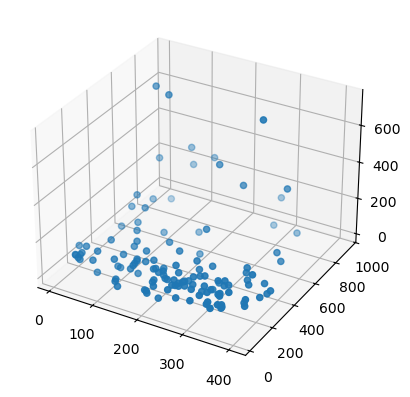

In [57]:
foot_fig_new = plt.figure().add_subplot(projection='3d')
foot_fig_new.scatter(new_df['X_transformed'], new_df['Y_transformed'], new_df['Z_transformed'])

We see that the compression is high, but we do indeed have the basic shape of a foot here. This looks very promising.

We need to un-normalize our data again, which would mean subtracting our original values that we added to get everything positive, and then dividing by 1000.

In [58]:
# Shift the X coordinate-->
new_df['X_transformed'] = new_df['X_transformed'] - 225

# Shift the Y coordinate-->
new_df['Y_transformed'] = new_df['Y_transformed'] - 762

# Shift the Z coordinate-->
new_df['Z_transformed'] = new_df['Z_transformed'] - 16

# Divide by 1000
new_df = new_df / 1000

In [59]:
new_df.head()

,X_transformed,Y_transformed,Z_transformed
0,-0.222,-0.562,0.055
1,-0.212,-0.628,0.050
2,-0.202,-0.622,0.054
3,-0.196,-0.679,0.089
4,-0.192,-0.643,0.084


Lets now recreate our scatter plots from earlier with our new data.

In [60]:
# Create the point chart between X and Y
xy_point_new = alt.Chart(new_df).mark_point().encode(
    x = alt.X('X_transformed').scale(domain=[-0.4,0.4]),
    y= alt.Y('Y_transformed').scale(domain=[-0.8,0.2])
).properties(
    width = 250,
    height = 350
)

# Create the point chart between X and Z
xz_point_new = alt.Chart(new_df).mark_point().encode(
    x = alt.X('X_transformed').scale(domain=[-0.4,0.4]),
    y= alt.Y('Z_transformed').scale(domain=[-0.1,0.8])
).properties(
    width = 250,
    height = 300
)

# Create the point chart between Y and Z
yz_point_new = alt.Chart(new_df).mark_point().encode(
    x = alt.X('Y_transformed').scale(domain=[-0.8,0.2]),
    y= alt.Y('Z_transformed').scale(domain=[-0.1,0.8])
).properties(
    width = 400,
    height = 300
)

In [61]:
vertex_point_new = (xz_point_new | yz_point_new) & xy_point_new
vertex_point_new

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.VConcatChart(...)

Lets also view the results side by side.

In [62]:
xz_point | xz_point_new

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.HConcatChart(...)

In [63]:
xy_point | xy_point_new

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.HConcatChart(...)

In [64]:
yz_point | yz_point_new

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.HConcatChart(...)

## Conclusion

Using a sliding 10x10x10 cube, we were able to successfully reduce the vertex count of our model by a factor of 6. This provides us with a reprodicible way to reduce the mesh density of a 3D object, especially when the finer detail modelling is not necessary. Reducing the size of the cube will reduce the compression ratio, as less points will get amalgamated in our pooling function. On the flip side, increasing the cube size will compress our object even further.

The next step will be to recreate the object based on this new vertex information. This will involve maintaing edge information as well, as well as creating some new edges as our scene becomes more and more compressed. I will explore this in further research.

I will also explore proven methods like `edge collapse` to achieve similar results.

### Attributions

1. human-foot-base-mesh credit to ferrumiron6, Creative Commons License https://creativecommons.org/licenses/by/4.0/